In [12]:
from PIL import Image

def split_panorama_with_overlap(image_path, num_splits=5, overlap_ratio=0.2):
    try:
        # Open the image
        img = Image.open(image_path)

        # Get the width and height of the image
        width, height = img.size

        # Calculate the width of each part
        part_width = width // num_splits

        # Calculate the overlap width
        overlap_width = int(part_width * overlap_ratio)

        # Split the image into parts with overlap
        parts = []
        for i in range(num_splits):
            left = i * (part_width - overlap_width)
            upper = 0
            right = min((i + 1) * part_width, width)
            lower = height
            parts.append(img.crop((left, upper, right, lower)))

        # Save the parts
        for i, part in enumerate(parts):
            part.save(f"part_{i+1}.jpg")  # You can change the file format as needed

        print(f"Panorama image has been successfully split into {num_splits} parts with overlap.")

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
split_panorama_with_overlap("/content/WhatsApp Image 2024-04-09 at 15.41.53_e09d7559.jpg", num_splits=5, overlap_ratio=0.2)


Panorama image has been successfully split into 5 parts with overlap.


In [1]:
import numpy as np
import cv2

def detect_feature_and_keypoints(image, method='SIFT'):
    if method == 'SIFT':
        descriptors = cv2.SIFT_create()
    elif method == 'ORB':
        descriptors = cv2.ORB_create(nfeatures=4000)  # Adjust the number of keypoints as needed
    elif method == 'AKAZE':
        akaze = cv2.AKAZE_create()
        keypoints, descriptors = akaze.detectAndCompute(image, None)
        keypoints = np.float32([kp.pt for kp in keypoints])
        return keypoints, descriptors

    keypoints, features = descriptors.detectAndCompute(image, None)
    keypoints = np.float32([i.pt for i in keypoints])
    return keypoints, features

def match_keypoints(KeypointsA, KeypointsB, featuresA, featuresB, lowe_ratio, max_Threshold):
    all_matches = get_all_possible_matches(featuresA, featuresB)
    valid_matches = get_all_valid_matches(all_matches, lowe_ratio)

    if len(valid_matches) <= 4:
        return None

    # construct the two sets of points
    points_A = np.float32([KeypointsA[i] for (_, i) in valid_matches])
    points_B = np.float32([KeypointsB[i] for (i, _) in valid_matches])
    (homograpgy, status) = compute_homography(points_A, points_B, max_Threshold)
    return valid_matches, homograpgy, status

def get_all_possible_matches(featuresA, featuresB):
    # compute the all matches using Euclidean distance. Opencv provide DescriptorMatcher_create() function for that
    match_instance = cv2.DescriptorMatcher_create("BruteForce")
    All_Matches = match_instance.knnMatch(featuresA, featuresB, 2)
    return All_Matches

def get_all_valid_matches(AllMatches, lowe_ratio):
    # to get all valid matches according to lowe concept..
    valid_matches = []
    for val in AllMatches:
        if len(val) == 2 and val[0].distance < val[1].distance * lowe_ratio:
            valid_matches.append((val[0].trainIdx, val[0].queryIdx))
    return valid_matches

def compute_homography(pointsA, pointsB, max_Threshold):
    return cv2.findHomography(pointsA, pointsB, cv2.RANSAC, max_Threshold)

def image_stitch(images, lowe_ratio=0.75, max_Threshold=4.0, match_status=False, method='SIFT'):
    # detect the features and keypoints from SIFT
    (imageB, imageA) = images
    (key_points_A, features_of_A) = detect_feature_and_keypoints(imageA, method)
    (key_points_B, features_of_B) = detect_feature_and_keypoints(imageB, method)

    # get the valid matched points
    Values = match_keypoints(key_points_A, key_points_B, features_of_A, features_of_B, lowe_ratio, max_Threshold)
    if Values is None:
        return None

    # get wrap perspective of image using computed homography
    (matches, Homography, status) = Values

    val = imageA.shape[1] + imageB.shape[1]
    result_image = cv2.warpPerspective(imageA, Homography, (val, imageA.shape[0]))

    result_image[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

    # check to see if the keypoint matches should be visualized
    if match_status:
        vis = draw_matches(imageA, imageB, key_points_A, key_points_B, matches, status)
        return result_image, vis

    return result_image

def draw_matches(imageA, imageB, KeypointsA, KeypointsB, matches, status):
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]

    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        if s == 1:
            ptA = (int(KeypointsA[queryIdx][0]), int(KeypointsA[queryIdx][1]))
            ptB = (int(KeypointsB[trainIdx][0]) + wA, int(KeypointsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
    return vis


In [2]:
import cv2
import imutils
from google.colab.patches import cv2_imshow

no_of_images = int(input("Enter the number of images you want to concatenate: "))
print("Enter the image names with extension in order of left to right in the way you want to concatenate: ")
# like tajm1.jpg, tajm2.jpg, tajm3.jpg .... tajmn.jpg

filename = []
for i in range(no_of_images):
    filename.append(input("Enter the %d image name along with path and extension: " % (i + 1)))

images = []
for i in range(no_of_images):
    images.append(cv2.imread(filename[i]))

# We need to modify the images width and height to keep our aspect ratio same across images
for i in range(no_of_images):
    images[i] = imutils.resize(images[i], width=400)

for i in range(no_of_images):
    images[i] = imutils.resize(images[i], height=400)


if no_of_images == 2:
    (result, matched_points) = image_stitch([images[0], images[1]], match_status=True)
else:
    (result, matched_points) = image_stitch([images[no_of_images - 2], images[no_of_images - 1]], match_status=True)
    for i in range(no_of_images - 2):
        (result, matched_points) = image_stitch([images[no_of_images - i - 3], result], match_status=True)

# show input images
for i in range(no_of_images):
    cv2_imshow(images[i])

# show the panorama image and valid matched points
#cv2_imshow(matched_points)
cv2_imshow(result)

# save panorama and matched_points images in output folder
cv2.imwrite("/content/matched_points.jpg", matched_points)
cv2.imwrite("/content/panorama_image.jpg", result)

cv2.waitKey(0)
cv2.destroyAllWindows()


ModuleNotFoundError: No module named 'imutils'

Truth:


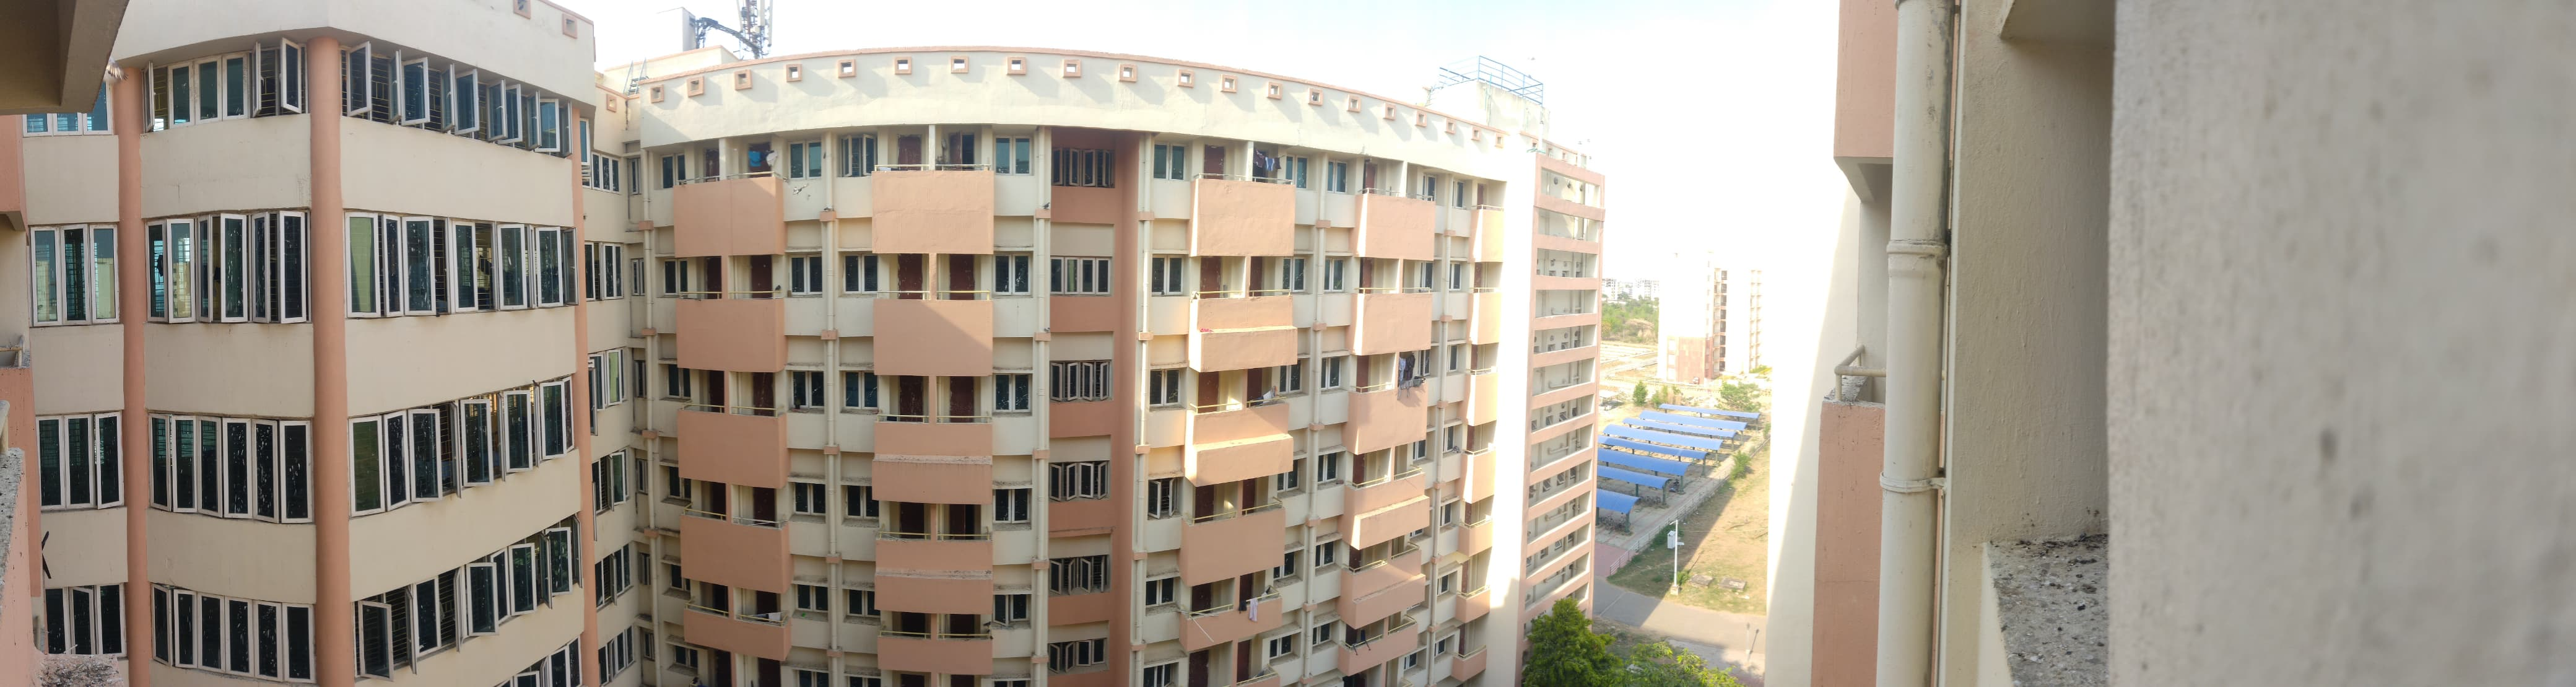

In [20]:
print("Truth:")
# Load the image
image_path = '/content/WhatsApp Image 2024-04-09 at 15.41.53_e09d7559.jpg'
image = cv2.imread(image_path)

# Display the image
cv2_imshow(image)

Enter the number of images you want to concatenate: 3
Enter the image names with extension in order of left to right in the way you want to concatenate: 
Enter the 1 image name along with path and extension: /content/img1.jpg
Enter the 2 image name along with path and extension: /content/img2.jpg
Enter the 3 image name along with path and extension: /content/img3.jpg


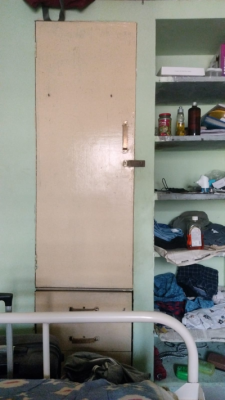

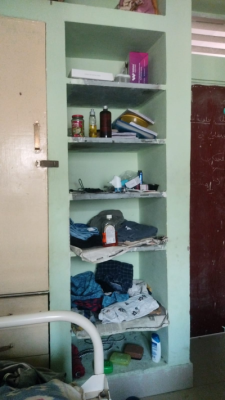

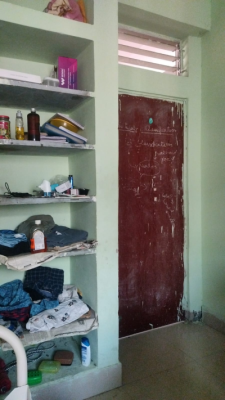

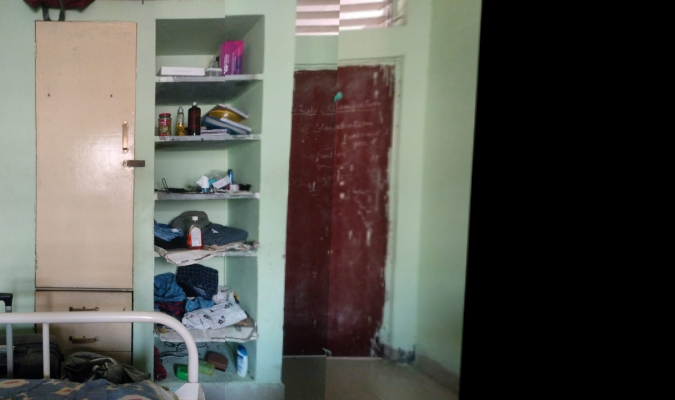

In [34]:
import numpy as np
import cv2

no_of_images = int(input("Enter the number of images you want to concatenate: "))
print("Enter the image names with extension in order of left to right in the way you want to concatenate: ")

filename = []
for i in range(no_of_images):
    filename.append(input("Enter the %d image name along with path and extension: " % (i + 1)))

images = []
for i in range(no_of_images):
    images.append(cv2.imread(filename[i]))

# We need to modify the images width and height to keep our aspect ratio same across images
for i in range(no_of_images):
    images[i] = imutils.resize(images[i], width=400)

for i in range(no_of_images):
    images[i] = imutils.resize(images[i], height=400)

if no_of_images == 2:
    (result, matched_points) = image_stitch([images[0], images[1]], match_status=True, method='ORB')
else:
    (result, matched_points) = image_stitch([images[no_of_images - 2], images[no_of_images - 1]], match_status=True, method='ORB')
    for i in range(no_of_images - 2):
        (result, matched_points) = image_stitch([images[no_of_images - i - 3], result], match_status=True, method='ORB')

# show input images
for i in range(no_of_images):
    cv2_imshow(images[i])

# show the panorama image and valid matched points
#cv2_imshow(matched_points)
cv2_imshow(result)

# save panorama and matched_points images in output folder
cv2.imwrite("/content/matched_points.jpg", matched_points)
cv2.imwrite("/content/panorama_image.jpg", result)

cv2.waitKey(0)
cv2.destroyAllWindows()

Enter the number of images you want to concatenate: 3
Enter the image names with extension in order of left to right in the way you want to concatenate: 
Enter the 1 image name along with path and extension: /content/img1.jpg
Enter the 2 image name along with path and extension: /content/img2.jpg
Enter the 3 image name along with path and extension: /content/img3.jpg


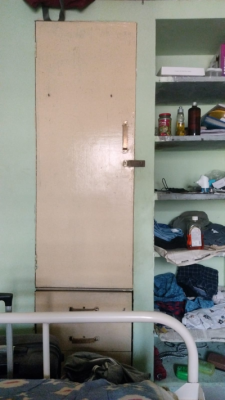

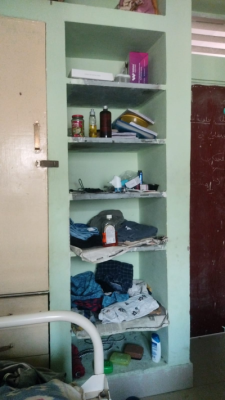

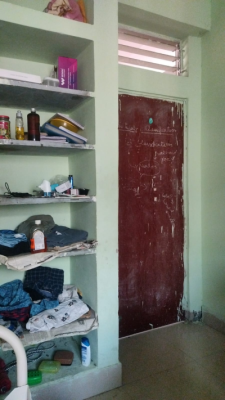

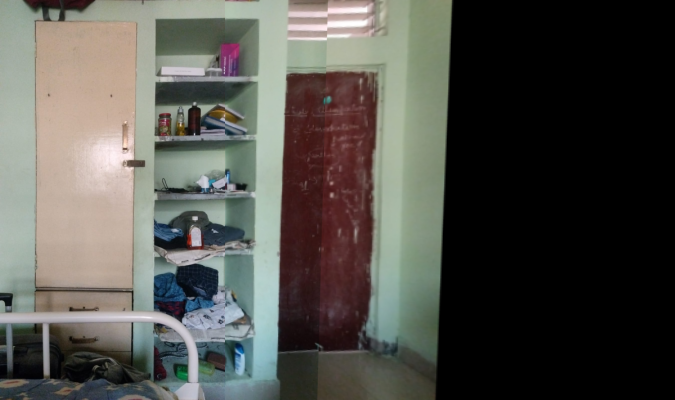

In [37]:
import numpy as np
import cv2

no_of_images = int(input("Enter the number of images you want to concatenate: "))
print("Enter the image names with extension in order of left to right in the way you want to concatenate: ")

filename = []
for i in range(no_of_images):
    filename.append(input("Enter the %d image name along with path and extension: " % (i + 1)))

images = []
for i in range(no_of_images):
    images.append(cv2.imread(filename[i]))

# We need to modify the images width and height to keep our aspect ratio same across images
for i in range(no_of_images):
    images[i] = imutils.resize(images[i], width=400)

for i in range(no_of_images):
    images[i] = imutils.resize(images[i], height=400)

if no_of_images == 2:
    (result, matched_points) = image_stitch([images[0], images[1]], match_status=True, method='AKAZE')
else:
    (result, matched_points) = image_stitch([images[no_of_images - 2], images[no_of_images - 1]], match_status=True, method='AKAZE')
    for i in range(no_of_images - 2):
        (result, matched_points) = image_stitch([images[no_of_images - i - 3], result], match_status=True, method='AKAZE')

# show input images
for i in range(no_of_images):
    cv2_imshow(images[i])

# show the panorama image and valid matched points
#cv2_imshow(matched_points)
cv2_imshow(result)

# save panorama and matched_points images in output folder
cv2.imwrite("/content/matched_points.jpg", matched_points)
cv2.imwrite("/content/panorama_image.jpg", result)

cv2.waitKey(0)
cv2.destroyAllWindows()